# N0_Kozlowski_Fig2_plot

A notebook to take the results of either finding the full logL on the simulated light curves,  or the MAP solution. We read in all results , and plot figures similar to Fig.2 in his paper. 

In [4]:
import numpy as np 
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib import rcParams 
from astroML.plotting.mcmc import convert_to_stdev
import celerite
from celerite import terms
from astropy.table import Table
from astropy.table import vstack
from astropy.table import Column
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18
import os
import scipy

In [320]:
#files = filter(os.path.isfile, glob.glob(resDir + "*"))
#files.sort(key=lambda x: os.path.getmtime(x))

In [22]:

# read in the files  with logL evaluated on a grid
# and calculate the expectation value .... 

simulation = 'SDSS'
resDir  = '../data_products/Simulated_DRW_Kozlowski/'+simulation+'/results/'#'/results/'# 
# /new_results/'

files = os.listdir(resDir)
loglike_results = {'lc_name': np.zeros_like(files),
                  'sigma_exp':np.zeros(len(files), dtype=float),
                  'tau_exp':np.zeros(len(files), dtype=float),
                 'sigma_MAP':np.zeros(len(files), dtype=float),
                 'tau_MAP':np.zeros(len(files), dtype=float),
                   'rho_in':np.zeros(len(files), dtype=float),
                   'tau_in':np.zeros(len(files), dtype=float),
                  # 'tau_MAP_err':np.zeros(len(files), dtype=float)
                  }
print('Using ', len(files), ' files')
N = 60 
rho_min, rho_max,  n_rho = 0.001, 15, 100
rho_grid = np.logspace(np.log10(rho_min), np.log10(rho_max), n_rho)
files.remove('.DS_Store')
for prior in ['Jeff2']:  #1', 'Jeff2']:

    for k in range(len(files)) : 
        fname = files[k]
        loglike_results['lc_name'][k] = fname[:-9] + '.dat'
        results = np.load(resDir+fname).item()

        # recover rho and tau : input parameters 
        #loglike_results['rho_in'][k] = rho_grid[int(fname[8:11])]
        loglike_results['rho_in'][k] = results[prior]['rho_in']
        loglike_results['tau_in'][k] = results[prior]['tau_in']

        # we are storing log Posterior ...
        logP = results[prior]['logPosterior']

        # read the MAP results 
        loglike_results['sigma_MAP'][k] = results[prior]['sigma_MAP']
        loglike_results['tau_MAP'][k] = results[prior]['tau_MAP']

        # we also store the actual grid....
        sigma_grid = results[prior]['sigma_grid']
        tau_grid   = results[prior]['tau_grid']

        # find the expectation value ... 
        dsigma =  sigma_grid[1] - sigma_grid[0]
        dtau = tau_grid[1] - tau_grid[0]

        logP -= logP.max()
        
        p_sigma = np.exp(logP).sum(1)
        p_sigma /= p_sigma.sum() * (dsigma)

        p_tau = np.exp(logP).sum(0)
        p_tau /= p_tau.sum() * (dtau)

        # find it with trapezoidal rule 
        loglike_results['sigma_exp'][k] = scipy.integrate.trapz(sigma_grid*p_sigma, 
                                                                      dx=dsigma)
        loglike_results['tau_exp'][k] = scipy.integrate.trapz(tau_grid*p_tau, 
                                                                    dx=dtau)

    print('Done')

    # store regardless of prior...
    loglike = Table(loglike_results)
    fname  = 'loglike_'+prior+'_'+str(int(N))+'_'+simulation+'.txt'
    print('Saved as ', fname)
    loglike.write(fname, format='ascii',overwrite=True)

    

Using  10001  files
Done
Saved as  loglike_Jeff2_60_SDSS.txt


In [19]:
# 

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Saved as  SDSS_Jeff2_MAP.png
Saved as  SDSS_Jeff2_expectation.png


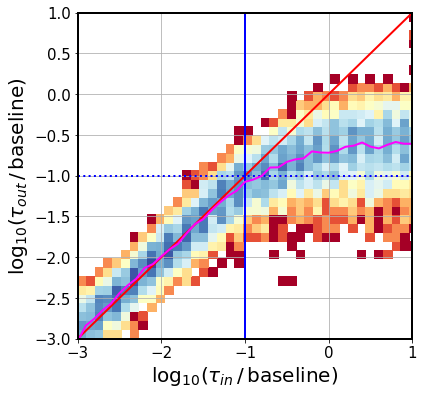

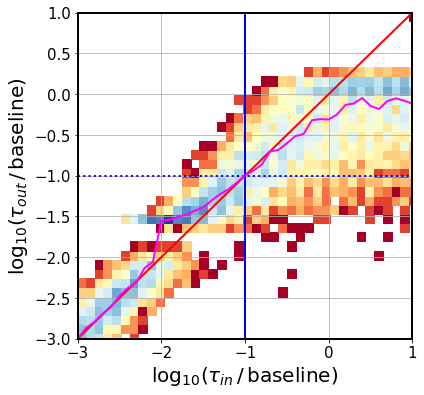

In [27]:
%matplotlib inline
from scipy.stats import binned_statistic_2d

prior='Jeff2'
simulation='SDSS'
N = 60 
fname = 'loglike_'+prior+'_'+str(int(N))+'_'+simulation+'.txt'
loglike = Table.read(fname, format='ascii')


t_exp = 8 * 365.0 # days 
rho_in = loglike['rho_in']
for label in ['MAP', 'expectation']:
    if label is 'MAP':
        rho_out  = loglike['tau_MAP']*np.sqrt(2) / t_exp
    elif label is 'expectation':
        rho_out  = loglike['tau_exp'] / t_exp

    fig,ax = plt.subplots(1,1,figsize=(6,6))
    x = np.log10(rho_in)
    y = np.log10(rho_out)

    stats = binned_statistic_2d(x, y, x, statistic='count', bins=40)
    z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
    z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
    z_reduce  =  z_sigma
    z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
    z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
    z_rot_flip = np.flipud(z_rot)
    z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)
    image = ax.pcolormesh(x_edges,y_edges, np.log10(z_masked), 
                             cmap=plt.cm.get_cmap('RdYlBu'))
    # labels...
    ax.set_xlabel(r'$\log_{10}(\tau_{in} \,/ \,\mathrm{baseline})$')
    ax.set_ylabel(r'$\log_{10}(\tau_{out}\,/\,\mathrm{baseline})$')

    # lines to guide the eye ...
    ax.grid()
    xlim = ax.get_xlim()
    x_line = np.arange(xlim[0], xlim[1],0.01)
    ax.plot(x_line,x_line, ls='-', lw=2, color='red')
    ax.axhline(-1, ls=':', lw=2, c='blue')
    ax.axvline(-1, ls='-', lw=2, c='blue')

    # calculate the median of log(rho_out)
    # Median of the log(y) is not the log(median(y)) .... 
    min_x, max_x , step_size = xlim[0],xlim[1], 0.1
    mean_x = np.arange(min_x, max_x+step_size , step_size)
    dx = 0.5 * step_size 
    median_y = np.zeros(len(mean_x))

    for j in range(len(median_y)):
        # take points that are within desired x_data limits for each bin
        # i.e. marginalize along y ( stack vertically)
        mask =  ((mean_x[j] - dx) < x)*(x<  (mean_x[j] + dx))
        median_y[j] = np.median(y[mask])

    ax.plot(mean_x[:-1], median_y[:-1], c = 'magenta',lw=2)#, s=50 , edgecolor='black')
    #ax.set_title(simulation+', ' +prior+', '+label)
    ax.set_ylim(-3,1)
    ax.set_xlim(-3,1)
    figname = simulation+'_'+prior+'_'+label+'.png'
    plt.savefig(figname, bbox_inches='tight')
    print('Saved as ', figname)

Investigate the pile-up around  log10(rho_out) of about -1.5 :

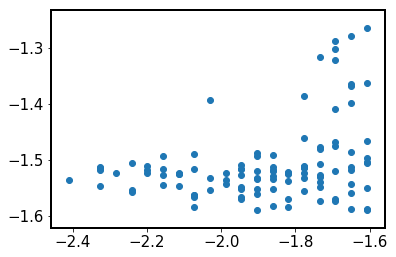

In [6]:
rho_in = loglike['rho_in']
rho_out = loglike['tau_exp'] / t_exp
m = (np.log10(rho_in)  < -1.6)*(-1.6 < np.log10(rho_out))
plt.scatter(np.log10(rho_in[m]), np.log10(rho_out[m]))

In [8]:
# find out which elements of the rho_in 
# grid suffered from that problem 
a = [int(x[len('DRW_rho-'):-len('_087.dat')]) for x in loglike[m]['lc_name']  ]
np.unique(a)

array([14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
       32, 33])

In [9]:
i = 14
loglike[m][i]

lc_name,sigma_exp,tau_exp,sigma_MAP,tau_MAP,rho_in,tau_in
str19,float64,float64,float64,float64,float64,float64
DRW_rho-027_009.dat,0.165599242529,94.2879352711,0.119094612603,40.3522408028,0.013770001252,40.2084036557


1) Plot the initial  log Posterior that was calculated for that light curve  ( but not stored, so I recalculate it here given the initial grid boundaries and the simulated light curve ) :

In [12]:
prior='Jeff1'
simulation = 'SDSS'
t_exp = 8 * 365.

fname = loglike[m][i]['lc_name'][:-4]
rho_in = loglike[m][i]['rho_in']
tau_in = rho_in * t_exp
sigma_in = 0.2 / np.sqrt(2)
print('tau_in ', tau_in, 'sigma_in ', sigma_in)
print(fname)

if simulation is 'SDSS' : 
    r = 17 # mag 
    variance = 0.013**2.0 + np.exp(2 * (r-23.36))
    t = np.loadtxt('t_SDSS.txt')
if simulation is 'OGLE' : 
    I = 18 # mag 
    variance = 0.004**2.0 + np.exp(1.63 * (I - 22.55))    
    t =  np.loadtxt('t_OGLE.txt')
#print(simulation,' noise stdev ', np.sqrt(variance))

# set the light curve directory 
outDir = '../data_products/Simulated_DRW_Kozlowski/'+simulation+'/'

# set the output directory 
resDir  = '../data_products/Simulated_DRW_Kozlowski/'+simulation+'/new_results/'

# read in hte light curve, add Gaussian noise 
# assume homoscedastic uncertainty... 
y = np.loadtxt(outDir+fname+'.txt')
noise = np.random.normal(loc=0,scale=np.sqrt(variance),size=len(t))
y += noise +10 
yerr = np.ones_like(t)* np.sqrt(variance)

kernel = terms.RealTerm(log_a = 2 * np.log(0.2) , 
                        log_c = np.log(1.0/100))
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(t, yerr)


tau_in  40.2084036557 sigma_in  0.141421356237
DRW_rho-027_009


In [69]:
y

array([  9.98192745,  10.00784224,  10.17538864,  10.01972853,
        10.11327332,  10.10799822,  10.07774994,  10.07750357,
        10.28454637,  10.06399349,   9.94214   ,  10.01022187,
        10.03607707,   9.91028303,   9.91797584,   9.91423026,
         9.96126887,   9.97959324,   9.93727735,   9.96692974,
         9.9752387 ,  10.00480676,  10.04325783,  10.06837322,
        10.03086733,  10.04233396,  10.01192736,  10.00978512,
         9.97789059,   9.96208366,   9.99902756,   9.95175512,
         9.79952259,   9.78716908,   9.81196019,   9.80357999,
         9.80256101,   9.78758207,   9.94013535,   9.96982441,
         9.93863748,   9.95147617,   9.96892827,   9.97163211,
        10.02647383,   9.95629534,   9.93937757,   9.84724329,
         9.84063124,   9.84801953,   9.84926633,   9.90325364,
         9.84069251,   9.91177638,  10.09724329,  10.19233288,
        10.10503462,   9.88857031,   9.89539664,   9.91193235])

Using prior  Jeff1


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log


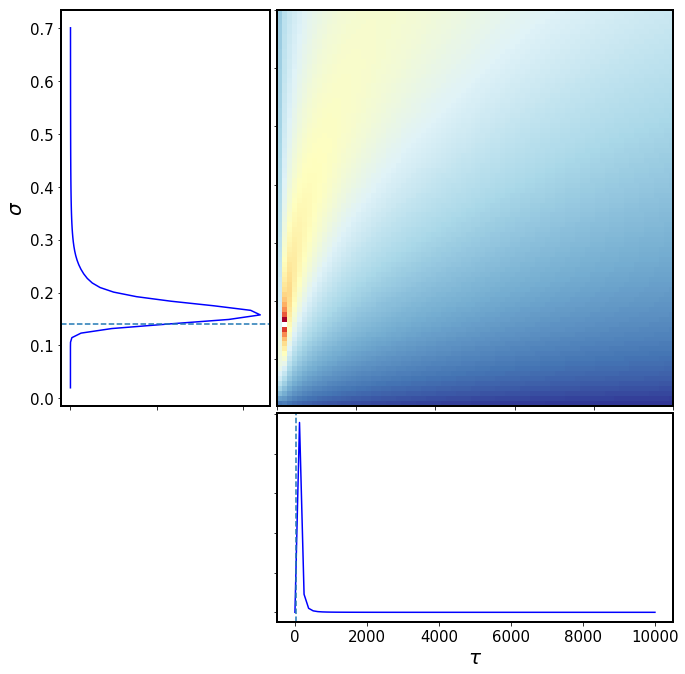

In [79]:
# 1) Investigate the logP space before we change the limits....

# functions for adaptative gridding .... 
def calculate_log_posterior(prior, params,y,gp):
    if prior is 'Jeff1' : # (1/sigma) * (1/tau) 
        def neg_log_like(params,y,gp):
            gp.set_parameter_vector(params)
            log_a = params[0]
            log_c = params[1]
            # - log_likelihood - log(prior)
            log_prior = - (log_a / 2.0) + log_c
            return -gp.log_likelihood(y, quiet=True) - log_prior
    
    if prior is 'Jeff2' : # (1/sigma_hat) * (1/tau) 
        def neg_log_like(params, y, gp):
            gp.set_parameter_vector(params)
            log_a = params[0]
            log_c = params[1]
             # - log_likelihood - log(prior)
            log_prior  = 0.5* (-np.log(2.0) - log_a + log_c  )
            return -gp.log_likelihood(y, quiet=True)  - log_prior
        
    return -neg_log_like(params, y, gp)

N = 80 
sig_lims = [0.02, 0.7]  ; tau_lims = [1,10000]
sigma_grid = np.linspace(sig_lims[0], sig_lims[1],N )
tau_grid  = np.linspace(tau_lims[0], tau_lims[1], N)

def calc_logP(sigma_grid, tau_grid,prior):
    log_a_grid = 2 * np.log(sigma_grid)
    log_c_grid = np.log(1/tau_grid)

    # loop over the likelihood space .... 
    print('Using prior ', prior)
    N = len(sigma_grid)
    logPosterior = np.zeros([N,N], dtype=float)
    for k in range(len(log_a_grid)):
        for l in range(len(log_c_grid)):
            params = [log_a_grid[k],log_c_grid[l]]    
            logPosterior[k,l] = calculate_log_posterior(prior, params,y,gp)
    return logPosterior

logPosterior = calc_logP(sigma_grid, tau_grid, prior)

def plot_logP(logP, sigma_grid, tau_grid, input_values):
    # plotting code 
    fig = plt.figure(figsize=(10, 10))
    tau_in, sigma_in = input_values['tau'], input_values['sigma']
    # first axis: likelihood contours
    ax1 = fig.add_axes((0.4, 0.4, 0.55, 0.55))
    ax1.xaxis.set_major_formatter(plt.NullFormatter())
    ax1.yaxis.set_major_formatter(plt.NullFormatter())

    # just for plotting, it is convenient to 
    # revert to negloglike 
    x = -logP
    shift = x-min(np.ravel(x))
    norm = np.sum(shift)
    z = shift / norm

    image = ax1.imshow(np.log(z), extent=(tau_grid[0], tau_grid[-1], 
                          sigma_grid[0], sigma_grid[-1]),
             cmap=plt.cm.get_cmap('RdYlBu'),
            aspect='auto', origin='lower')
    ax1.set_ylabel(r'$\sigma$')
    ax1.set_xlabel(r'$\tau$')

    # second axis: marginalized over sigma
    ax2 = fig.add_axes((0.1, 0.4, 0.29, 0.55))
    ax2.xaxis.set_major_formatter(plt.NullFormatter())
    p_sigma = np.exp(logP).sum(1)
    ax2.plot(p_sigma, sigma_grid, '-b')
    ax2.set_ylabel(r'$\sigma$')
    ax2.axhline(sigma_in, ls='--')

    # third axis: marginalized over tau
    ax3 = fig.add_axes((0.4, 0.1, 0.55, 0.29))
    p_tau = np.exp(logP).sum(0)
    ax3.yaxis.set_major_formatter(plt.NullFormatter())
    ax3.plot(tau_grid, p_tau, '-b')
    ax3.set_xlabel(r'$\tau$')
    ax3.axvline(tau_in, ls='--')


# 2) plot the initial log Posterior, on the starting grid 
plot_logP(logPosterior, sigma_grid, tau_grid, {'tau':tau_in, 'sigma':sigma_in})

2) Now find the new grid limits, and see how it should look like  - are we computing it in the right way ? 



[13 14 15 16 17 18 19 20 21 22 23]
13 23 0.131898734177 0.217974683544
2 : Resolved peak :  at least two points above threshold 
2b : Left edge of the peak in the middle 
3b : Right edge of the peak in the middle 
New  sigma  limits are:  [0.11468354430379746, 0.22658227848101262]


[1]
1 1 127.569620253 127.569620253
1 : Marginally resolved peak : only one point above threshold
1a : Narrow peak close to the beginning of the grid 
New  tau  limits are:  [0.84999999999999998, 254.13924050632912]


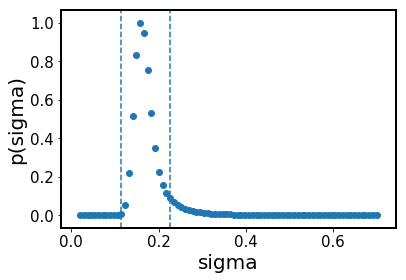

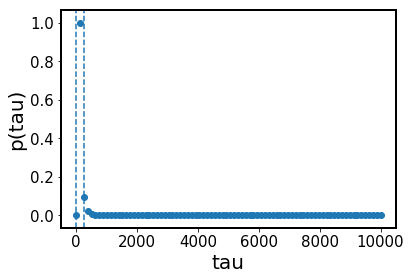

In [96]:
def find_new_limits(grid, logP, param = 'sigma', threshold=0.1 ,
                    verbose=True):
    print('\n')
    dx = grid[1] - grid[0]
    if param is 'tau':
        p_x = np.exp(logP).sum(0)
    if param is 'sigma':
        p_x = np.exp(logP).sum(1)
    p_x /= p_x.sum() * (dx)  # this ensures probability adds up to 1 
    p_x /= max(p_x)  # this ensures that maximum prob is 1 
    print(np.where(p_x > threshold)[0])
    
    if np.sum(p_x > threshold) > 0 : 
        # this assumes that there is at least one point that is above the thresho
        min_idx = np.where(p_x > threshold)[0][0]  
        max_idx = np.where(p_x > threshold)[0][-1]
    else:
        print('Error : not even a single point above the threshold ')
        return
    
    print(min_idx, max_idx, grid[min_idx], grid[max_idx])
    
    Q = 2 # number of grid points to classify proximity to either edge 
    
    
    # Unresolved peak : smallest index above threshold is the 
    # same as the largest index above threshold 
    if min_idx == max_idx : 
        print('1 : Marginally resolved peak : only one point above threshold')
        
        if min_idx <= Q: 
            # case where the beginning of grid is the beginning of peak.... 
            print('1a : Narrow peak close to the beginning of the grid ')
            new_min = 0.85 * grid[0] 
            new_max = grid[Q]
                
        if (Q < min_idx)*(min_idx<len(grid)-Q) :
            print('1b : Narrow peak in the middle ')
            new_min = grid[min_idx-Q]
            new_max = grid[max_idx+Q]

        if  len(grid)-Q <=  min_idx :
            print('1c : Narrow peak close to the end of the grid ')
            new_min = grid[min_idx-Q]
            new_max = grid[max_idx]


    # resolved peak : the smallest point above the threshold is not the same 
    # as the largest point above the threshold 
    
    if min_idx < max_idx : 
        print('2 : Resolved peak :  at least two points above threshold ')
        
        # fist : the beginning of the resolved peak 
        if min_idx <= Q : 
            print('2a : Left edge of the peak close to the original grid start')
            new_min = 0.85 * min(grid) # decrease by 25% 
            
        if (Q < min_idx)*(min_idx<len(grid)-Q) : 
            print('2b : Left edge of the peak in the middle ')
            new_min = grid[min_idx-Q] # move to the left by Q steps 
            
        if min_idx >= (len(grid) -Q) : 
            print('2c : Left edge of the peak close to the grid end ')
            new_min = grid[min_idx-Q] # move to the left by Q steps 
            
        # second :  the end of the resolved peak 
        if max_idx <= Q : 
            print('3a : Right edge of th epeak close to the original grid start')
            new_max = grid[max_idx+Q]
            
        if (Q < max_idx) * (max_idx < len(grid)-Q) : 
            print('3b : Right edge of the peak in the middle ')
            new_max = grid[max_idx+1]
            
        if max_idx >= (len(grid)-Q ) : 
            print('3c : Right edge of the peak close to the grid end')
            new_max = 1.25 * max(grid) # increase by 25% 
            
    new_limits = [new_min, new_max]
    
    # plotting the p_x 
    fig,ax = plt.subplots(1,1)
    ax.scatter(grid, p_x, )
    ax.set_xlabel(param)
    ax.set_ylabel('p('+param+')')
    ax.axvline(new_min, ls='--')
    ax.axvline(new_max, ls='--')
    
    print('New ',param,' limits are: ', new_limits)
    
    return new_limits,p_x

# find new limits 
sig_lims_new,p_x = find_new_limits(sigma_grid,logPosterior, param = 'sigma',)
tau_lims_new,p_x = find_new_limits(tau_grid, logPosterior,  param = 'tau',)



In [72]:
sig_lims_new

[0.11468354430379746, 0.23518987341772149]

Using prior  Jeff1


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log


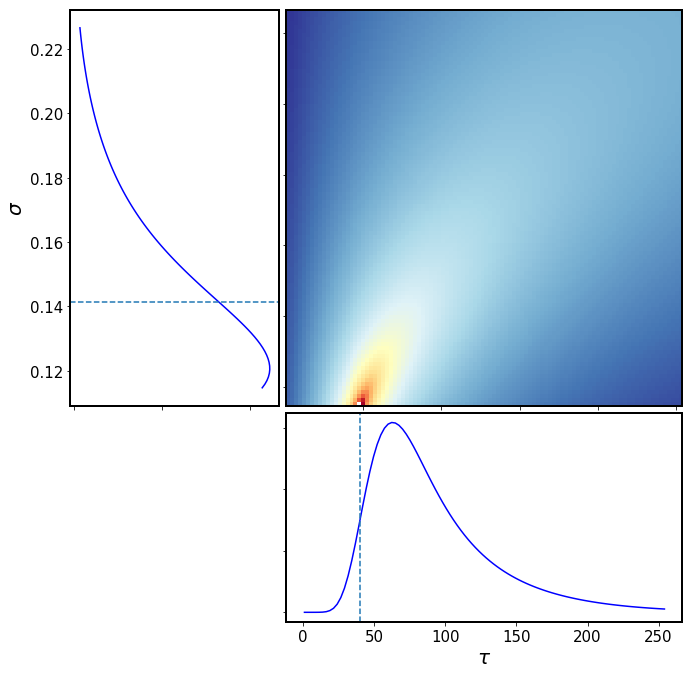

In [98]:
# span the new grid given the new limits 
N  = 100 
sigma_grid_new = np.linspace(sig_lims_new[0], sig_lims_new[1], N )
tau_grid_new  = np.linspace(tau_lims_new[0], tau_lims_new[1], N)


# calculate log Posterior on a new grid 
logPosterior_new = calc_logP(sigma_grid_new, tau_grid_new, prior)

# 2) Plot the logP after we change the limits 
plot_logP(logPosterior_new, sigma_grid_new, tau_grid_new, 
          {'tau':tau_in, 'sigma':sigma_in})




In [99]:
# find the expectation value ... 
dsigma =  sigma_grid_new[1] - sigma_grid_new[0]
dtau = tau_grid_new[1] - tau_grid_new[0]

p_sigma = np.exp(logPosterior_new).sum(1)
p_sigma /= p_sigma.sum() * (dsigma)

p_tau = np.exp(logPosterior_new).sum(0)
p_tau /= p_tau.sum() * (dtau)

# find it with trapezoidal rule 
sigma_exp = scipy.integrate.trapz(sigma_grid_new*p_sigma, dx=dsigma)
tau_exp = scipy.integrate.trapz(tau_grid_new*p_tau, dx=dtau)

print(sigma_exp, tau_exp)

0.14353390459 89.351868823


Read in the log Posterior that got stored ... 

In [77]:
tau_in

44.309777697812279

2D MAP values  are sigma_MAP 0.115922395873
and tau_MAP 36.4728778961


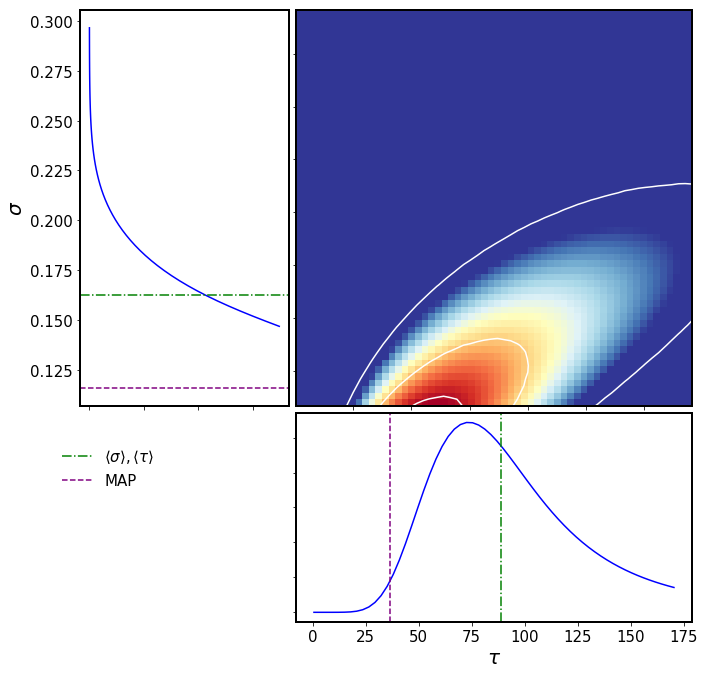

In [29]:
import matplotlib.lines as mlines
prior='Jeff1'
results = np.load(resDir+fname+'_logP.npy').item()

# we are storing log Posterior ...
logP = results[prior]['logPosterior']

# read the MAP results 
sigma_MAP =  results[prior]['sigma_MAP']
tau_MAP   = results[prior]['tau_MAP']

# we also store the actual grid....
sigma_grid = results[prior]['sigma_grid']
tau_grid   = results[prior]['tau_grid']

# find the expectation value ... 
dsigma =  sigma_grid[1] - sigma_grid[0]
dtau = tau_grid[1] - tau_grid[0]

p_sigma = np.exp(logP).sum(1)
p_sigma /= p_sigma.sum() * (dsigma)

p_tau = np.exp(logP).sum(0)
p_tau /= p_tau.sum() * (dtau)

# find it with trapezoidal rule 
sigma_exp = scipy.integrate.trapz(sigma_grid*p_sigma, dx=dsigma)
tau_exp = scipy.integrate.trapz(tau_grid*p_tau, dx=dtau)

print('2D MAP values  are sigma_MAP', sigma_MAP)
print('and tau_MAP', tau_MAP)

# plot the results
fig = plt.figure(figsize=(10, 10))

# first axis: likelihood contours
ax1 = fig.add_axes((0.4, 0.4, 0.55, 0.55))
ax1.xaxis.set_major_formatter(plt.NullFormatter())
ax1.yaxis.set_major_formatter(plt.NullFormatter())

# just for plotting, it is convenient to 
# revert to negloglike 
x = -logP
shift = x-min(np.ravel(x))
norm = np.sum(shift)
z = shift / norm

image = ax1.imshow(z, extent=(tau_grid[0], tau_grid[-1], 
                      sigma_grid[0], sigma_grid[-1]),
         cmap=plt.cm.get_cmap('RdYlBu'),vmax=1e-4,
        aspect='auto', origin='lower')

# second axis: marginalized over sigma
ax2 = fig.add_axes((0.1, 0.4, 0.29, 0.55))
ax2.xaxis.set_major_formatter(plt.NullFormatter())
ax2.plot(p_sigma, sigma_grid, '-b')
ax2.set_ylabel(r'$\sigma$')

color_dic = {'exp':'green', 'Celerite':'purple'}
ls_dic = {'exp': '-.', 'Celerite':'--', 'Chelsea':'-.'}
label_dic = {'exp':r'$\langle \sigma \rangle, \langle \tau \rangle$','Celerite':'MAP', 
           }
# note :  MAP stands for Maximum A Posteriori  probability estimate 
source_dic = {'exp':sigma_exp, 'Celerite': sigma_MAP}
ax_legend_handles = []

for source in ['exp', 'Celerite']:
    ax2.axhline(source_dic[source], ls=ls_dic[source], label=label_dic[source],
               color=color_dic[source])
    line = mlines.Line2D([], [], color=color_dic[source],  ls=ls_dic[source],
                         label=label_dic[source])
    ax_legend_handles.append(line)

# third axis: marginalized over tau
ax3 = fig.add_axes((0.4, 0.1, 0.55, 0.29))
ax3.yaxis.set_major_formatter(plt.NullFormatter())
ax3.plot(tau_grid, p_tau, '-b')
ax3.set_xlabel(r'$\tau$')

source_dic = {'exp':tau_exp, 'Celerite': tau_MAP}
for source in ['exp', 'Celerite']:
    ax3.axvline(source_dic[source], ls=ls_dic[source], label=label_dic[source],
               color=color_dic[source])

# add legend... 
legend_ax = fig.add_axes([0.1, 0.1, 0.29, 0.29])     #  (x0 ,y0  , dx,  dy )  
legend_ax.legend(loc='upper left', handles = ax_legend_handles, frameon=False,
                 fontsize=15, bbox_to_anchor=(-0.15, 0.9))
legend_ax.axis('off')

# add colorbar for logL ... 
# I'm not sure of colorbar 
# makes sense, given that it's all
# just an illustration of shape...
plot_cbar = False
if plot_cbar: 
    colorbar_ax = fig.add_axes([0.97, 0.4, 0.02, 0.55])     #  (x0 ,y0  , dx,  dy )  
    colorbar = plt.colorbar(image, cax = colorbar_ax, orientation='vertical')
    tick_locator = ticker.MaxNLocator(nbins=5)
    colorbar.locator = tick_locator
    colorbar.update_ticks()
    colorbar.set_label(r'$log(posterior)$', fontsize=25)

# add the contours of standard deviation ... 
ax1.contour(tau_grid, sigma_grid, convert_to_stdev(z),
           levels=(0.683, 0.955, 0.997), colors='white') 
